In [1]:
import os

base_path = "dataset"

folders = ["2_crawling","3_crying","4_dancing","5_eating","7_falling_slide","8_falling","9_playing_w_animals","10_playing_w_toy","12_smiling","15_walking"]

video_label_dict = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(folder_path, file)
            video_label_dict[video_path] = folder

print(video_label_dict)

{'dataset/2_crawling/crawling016.mp4': '2_crawling', 'dataset/2_crawling/crawling022.mp4': '2_crawling', 'dataset/2_crawling/crawling017.mp4': '2_crawling', 'dataset/2_crawling/crawling007.mp4': '2_crawling', 'dataset/2_crawling/crawling061.mp4': '2_crawling', 'dataset/2_crawling/crawling070.mp4': '2_crawling', 'dataset/2_crawling/crawling076.mp4': '2_crawling', 'dataset/2_crawling/crawling006.mp4': '2_crawling', 'dataset/2_crawling/crawling060.mp4': '2_crawling', 'dataset/2_crawling/crawling004.mp4': '2_crawling', 'dataset/2_crawling/crawling036.mp4': '2_crawling', 'dataset/2_crawling/crawling074.mp4': '2_crawling', 'dataset/2_crawling/crawling067.mp4': '2_crawling', 'dataset/2_crawling/crawling003.mp4': '2_crawling', 'dataset/2_crawling/crawling035.mp4': '2_crawling', 'dataset/2_crawling/crawling010.mp4': '2_crawling', 'dataset/2_crawling/crawling054.mp4': '2_crawling', 'dataset/2_crawling/crawling001.mp4': '2_crawling', 'dataset/2_crawling/crawling019.mp4': '2_crawling', 'dataset/2_

In [2]:
video_label_list = list(video_label_dict.items())
video_paths = list(video_label_dict.keys())
video_labels = list(video_label_dict.values())

In [3]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {
    "2_crawling": 0,
    "3_crying": 1,
    "4_dancing": 2,
    "5_eating": 3,
    "7_falling_slide": 4,
    "8_falling": 5,
    "9_playing_w_animals": 6,
    "10_playing_w_toy": 7,
    "12_smiling": 8,
    "15_walking": 9,
}
label_encoder = LabelEncoder()
label_encoder.fit([label_mapping[label] for label in video_labels])
labels_encoder = label_encoder.transform([label_mapping[label] for label in video_labels])

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and temporary (30%) sets
train_video_paths, test_video_paths, train_video_labels, test_video_labels = train_test_split(
    video_paths, labels_encoder, test_size=0.3, stratify=video_labels, random_state=42
)

# Split the temporary data into testing (20% of original data) and validation (10% of original data) sets
val_video_paths, test_video_paths, val_video_labels, test_video_labels = train_test_split(
    test_video_paths, test_video_labels, test_size=2/3, stratify=test_video_labels, random_state=42
)


In [5]:
len(train_video_paths)

213

In [6]:
len(test_video_paths)

62

In [7]:
len(val_video_paths)

30

In [8]:
import cv2
import pandas as pd

# Helper function to extract frames from a video using OpenCV
def extract_frames(video_path, frames_to_select, output_folder, img_format=".png"):
    video = cv2.VideoCapture(video_path)
    frame_list = []
    frame_num = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if frame_num in frames_to_select:
            img_path = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame{frame_num}{img_format}")
            cv2.imwrite(img_path, frame)  # Write frame image to disk
            frame_list.append(img_path)
        frame_num += 1
    video.release()
    return frame_list

In [9]:
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import timm

In [10]:
# Define the PyTorch Dataset
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame_labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame_labels_df)

    def __getitem__(self, idx):
        image = Image.open(self.frame_labels_df.iloc[idx]["image_path"])
        label = self.frame_labels_df.iloc[idx]["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
# Specify transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
# Load the Dataset
train_dataset = ImageDataset("ViT_output/train.csv", transform=transform)
test_dataset = ImageDataset("ViT_output/test.csv", transform=transform)
val_dataset = ImageDataset("ViT_output/val.csv", transform=transform)

In [13]:
# Define the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [14]:
import torch
import timm

# Load the pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze the weights of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
num_classes = 10  # Number of classes in your dataset
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Define the dropout rate
dropout_rate = 0.5

# Set the dropout rate for the 'head_drop' layer
model.head_drop.p = dropout_rate

# Print the modified model
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [15]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [16]:
import matplotlib.pyplot as plt
# Create lists to store the loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Set the number of epochs
num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels)

        # print statistics
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_dataloader.dataset)
    train_acc = correct_predictions.double() / len(train_dataloader.dataset) *100
    
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc/100)
    

    #Validation phase
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item()
            correct_predictions += torch.sum(preds == labels)
    
    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = correct_predictions.double() / len(test_dataloader.dataset) *100
    

    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc/100)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 1/10: Train Loss: 0.2668, Train Acc: 28.99%, Test Loss: 0.2128, Test Acc: 45.44%
Epoch 2/10: Train Loss: 0.1649, Train Acc: 55.25%, Test Loss: 0.1884, Test Acc: 50.00%
Epoch 3/10: Train Loss: 0.1193, Train Acc: 69.67%, Test Loss: 0.1783, Test Acc: 51.03%
Epoch 4/10: Train Loss: 0.0992, Train Acc: 75.36%, Test Loss: 0.1758, Test Acc: 50.52%
Epoch 5/10: Train Loss: 0.0832, Train Acc: 80.70%, Test Loss: 0.1746, Test Acc: 51.29%
Epoch 6/10: Train Loss: 0.0719, Train Acc: 84.03%, Test Loss: 0.1752, Test Acc: 51.03%
Epoch 7/10: Train Loss: 0.0652, Train Acc: 85.89%, Test Loss: 0.1739, Test Acc: 51.03%
Epoch 8/10: Train Loss: 0.0592, Train Acc: 87.54%, Test Loss: 0.1746, Test Acc: 51.64%
Epoch 9/10: Train Loss: 0.0539, Train Acc: 89.47%, Test Loss: 0.1747, Test Acc: 51.38%
Epoch 10/10: Train Loss: 0.0497, Train Acc: 90.08%, Test Loss: 0.1762, Test Acc: 50.95%


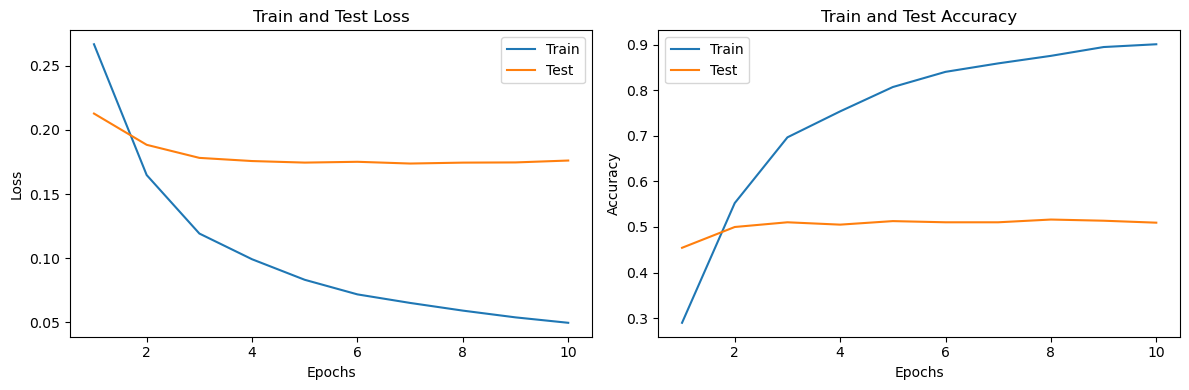

In [17]:
# Plotting the curves
epochs = range(1, num_epochs+1)

# Plotting loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train')
plt.plot(epochs, test_loss_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, [x.item() for x in train_acc_values], label='Train')
plt.plot(epochs, [x.item() for x in test_acc_values], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
from collections import Counter
def predict_video_label(video_path, model, transform, device):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Calculate the total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Select every 10th frame
    frames_to_select = list(range(0, total_frames, 10))

    # Collect labels for each frame
    frame_labels = []

    # For each frame, convert to tensor, predict the label, and store the result
    for i in range(total_frames):
        ret, frame = video.read()
        if not ret:
            break

        # Process every 10th frame
        if i in frames_to_select:
            # Convert the frame to RGB (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert the NumPy array to a PIL image
            pil_image = Image.fromarray(frame)

            # Apply the transformations
            image_tensor = transform(pil_image)

            # Add an extra dimension at the beginning of the tensor
            image_tensor = image_tensor.unsqueeze(0).to(device)

            # Pass the tensor to the model and get the predicted label
            output = model(image_tensor)

            # Convert output probabilities to predicted class
            _, predicted = torch.max(output, 1)

            # Append the predicted label to the frame_labels list
            frame_labels.append(predicted.item())

    # Release the video file
    video.release()

    # Calculate the most common label among all frames (top 1)
    top1_label = max(frame_labels, key=frame_labels.count)

    # Calculate the top 5 most common labels among all frames
    top5_labels = [label for label, count in Counter(frame_labels).most_common(5)]
    
    return top1_label, top5_labels

 

In [19]:
def calculate_accuracy(video_paths, true_labels, model, transform, device):
    correct_predictions_top1 = 0
    correct_predictions_top5 = 0

    # For each video and its true label
    for video_path, true_label in zip(video_paths, true_labels):
        # Predict the top 1 and top 5 labels of the video
        top1_label, top5_labels = predict_video_label(video_path, model, transform, device)

        # Check if the true label is in the top 1 and top 5 predicted labels
        if true_label == top1_label:
            correct_predictions_top1 += 1
        if true_label in top5_labels:
            correct_predictions_top5 += 1

    # Calculate the accuracy as the ratio of correct predictions to total videos
    accuracy_top1 = correct_predictions_top1 / len(video_paths)
    accuracy_top5 = correct_predictions_top5 / len(video_paths)

    return accuracy_top1, accuracy_top5

In [20]:
accuracy_top1, accuracy_top5 = calculate_accuracy(val_video_paths, val_video_labels, model, transform, device)

print(f"The prediction accuracy_top1 is: {accuracy_top1 * 100:.2f}%")
print(f"The prediction accuracy_top5 is: {accuracy_top5 * 100:.2f}%")

The prediction accuracy_top1 is: 43.33%
The prediction accuracy_top5 is: 93.33%


In [21]:
# Initialize a dictionary to store the counts for each true label
label_counts = {}

# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    # Check if the true label exists in the dictionary
    if true_label in label_counts:
        label_counts[true_label] += 1
    else:
        label_counts[true_label] = 1

# Sort the label counts by true label
sorted_counts = sorted(label_counts.items())

# Print the counts for each true label
print("Video Counts by True Label:")
for label, count in sorted_counts:
    print(f"True Label: {label}, Video Count: {count}")


Video Counts by True Label:
True Label: 0, Video Count: 3
True Label: 1, Video Count: 3
True Label: 2, Video Count: 2
True Label: 3, Video Count: 2
True Label: 4, Video Count: 4
True Label: 5, Video Count: 4
True Label: 6, Video Count: 3
True Label: 7, Video Count: 2
True Label: 8, Video Count: 3
True Label: 9, Video Count: 4


In [22]:
# Initialize dictionaries to store counts of true labels and correct predictions
label_counts = {}
correct_counts = {}

# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    predicted_label, _ = predict_video_label(video_path, model, transform, device)

    # Increment the count for the true label
    if true_label in label_counts:
        label_counts[true_label] += 1
    else:
        label_counts[true_label] = 1

    # Check if the prediction is correct
    if true_label == predicted_label:
        # Increment the count for the correct prediction
        if true_label in correct_counts:
            correct_counts[true_label] += 1
        else:
            correct_counts[true_label] = 1

# Calculate and print the accuracy by true label
print("Accuracy by True Label:")
sorted_labels = sorted(label_counts.keys())
for label in sorted_labels:
    count = label_counts[label]
    accuracy = correct_counts.get(label, 0) / count
    print(f"True Label: {label}, Accuracy: {accuracy}")

Accuracy by True Label:
True Label: 0, Accuracy: 0.6666666666666666
True Label: 1, Accuracy: 0.6666666666666666
True Label: 2, Accuracy: 0.0
True Label: 3, Accuracy: 0.5
True Label: 4, Accuracy: 0.75
True Label: 5, Accuracy: 0.5
True Label: 6, Accuracy: 0.6666666666666666
True Label: 7, Accuracy: 0.0
True Label: 8, Accuracy: 0.0
True Label: 9, Accuracy: 0.25


In [23]:
# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    predicted_label, _ = predict_video_label(video_path, model, transform, device)


    print(f"Video Path: {video_path}, True Label: {true_label}, Predicted Label: {predicted_label}")



Video Path: dataset/2_crawling/crawling020.mp4, True Label: 0, Predicted Label: 0
Video Path: dataset/3_crying/crying073.mp4, True Label: 1, Predicted Label: 9
Video Path: dataset/2_crawling/crawling074.mp4, True Label: 0, Predicted Label: 9
Video Path: dataset/9_playing_w_animals/playing_w_animals080.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/15_walking/walking060.mp4, True Label: 9, Predicted Label: 9
Video Path: dataset/8_falling/falling010.mp4, True Label: 5, Predicted Label: 9
Video Path: dataset/12_smiling/smiling003.mp4, True Label: 8, Predicted Label: 1
Video Path: dataset/4_dancing/dancing010.mp4, True Label: 2, Predicted Label: 6
Video Path: dataset/7_falling_slide/falling_slide062.mp4, True Label: 4, Predicted Label: 4
Video Path: dataset/2_crawling/crawling054.mp4, True Label: 0, Predicted Label: 0
Video Path: dataset/9_playing_w_animals/playing_w_animals090.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/7_falling_slide/falling_slide056.mp4, True

In [24]:
# from IPython.display import Video

# video_path = "dataset/4_dancing/dancing010.mp4"

# Video(video_path)


In [25]:
def predict_video_label(video_path, model, transform, device):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Calculate the total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Select every 10th frame
    frames_to_select = list(range(0, total_frames, 10))

    # Collect labels for each frame and their probabilities
    frame_probs = []

    # For each frame, convert to tensor, predict the label, and store the result
    for i in range(total_frames):
        ret, frame = video.read()
        if not ret:
            break

        # Process every 10th frame
        if i in frames_to_select:
            # Convert the frame to RGB (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert the NumPy array to a PIL image
            pil_image = Image.fromarray(frame)

            # Apply the transformations
            image_tensor = transform(pil_image)

            # Add an extra dimension at the beginning of the tensor
            image_tensor = image_tensor.unsqueeze(0).to(device)

            # Pass the tensor to the model and get the predicted label
            output = model(image_tensor)

            # Convert output logits to probabilities
            probs = F.softmax(output, dim=1)

            # Get top class probabilities and their indices
            top_probs, top_indices = probs.topk(1, dim=1)

            # Append the predicted label and its probability to the frame_probs list
            frame_probs.append((top_indices.item(), top_probs.item()))

    # Release the video file
    video.release()

    # Sort by probabilities
    frame_probs.sort(key=lambda x: x[1], reverse=True)

    # Get top 1 and top 5 labels based on highest probabilities
    top1_label = frame_probs[0][0]
    top5_labels = [label for label, prob in frame_probs[:5]]

    return top1_label, top5_labels


In [26]:
import torch.nn.functional as F

accuracy_top1, accuracy_top5 = calculate_accuracy(val_video_paths, val_video_labels, model, transform, device)

print(f"The prediction accuracy_top1 is: {accuracy_top1 * 100:.2f}%")
print(f"The prediction accuracy_top5 is: {accuracy_top5 * 100:.2f}%")

The prediction accuracy_top1 is: 46.67%
The prediction accuracy_top5 is: 56.67%


In [27]:
# Initialize a dictionary to store the counts for each true label
label_counts = {}

# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    # Check if the true label exists in the dictionary
    if true_label in label_counts:
        label_counts[true_label] += 1
    else:
        label_counts[true_label] = 1

# Sort the label counts by true label
sorted_counts = sorted(label_counts.items())

# Print the counts for each true label
print("Video Counts by True Label:")
for label, count in sorted_counts:
    print(f"True Label: {label}, Video Count: {count}")

Video Counts by True Label:
True Label: 0, Video Count: 3
True Label: 1, Video Count: 3
True Label: 2, Video Count: 2
True Label: 3, Video Count: 2
True Label: 4, Video Count: 4
True Label: 5, Video Count: 4
True Label: 6, Video Count: 3
True Label: 7, Video Count: 2
True Label: 8, Video Count: 3
True Label: 9, Video Count: 4


In [28]:
# Initialize dictionaries to store counts of true labels and correct predictions
label_counts = {}
correct_counts = {}

# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    predicted_label, _ = predict_video_label(video_path, model, transform, device)

    # Increment the count for the true label
    if true_label in label_counts:
        label_counts[true_label] += 1
    else:
        label_counts[true_label] = 1

    # Check if the prediction is correct
    if true_label == predicted_label:
        # Increment the count for the correct prediction
        if true_label in correct_counts:
            correct_counts[true_label] += 1
        else:
            correct_counts[true_label] = 1

# Calculate and print the accuracy by true label
print("Accuracy by True Label:")
sorted_labels = sorted(label_counts.keys())
for label in sorted_labels:
    count = label_counts[label]
    accuracy = correct_counts.get(label, 0) / count
    print(f"True Label: {label}, Accuracy: {accuracy}")

Accuracy by True Label:
True Label: 0, Accuracy: 0.6666666666666666
True Label: 1, Accuracy: 0.6666666666666666
True Label: 2, Accuracy: 0.0
True Label: 3, Accuracy: 0.5
True Label: 4, Accuracy: 0.75
True Label: 5, Accuracy: 0.75
True Label: 6, Accuracy: 0.6666666666666666
True Label: 7, Accuracy: 0.0
True Label: 8, Accuracy: 0.0
True Label: 9, Accuracy: 0.25


In [29]:
# Iterate over the video paths and make predictions
for video_path, true_label in zip(val_video_paths, val_video_labels):
    predicted_label, _ = predict_video_label(video_path, model, transform, device)

    print(f"Video Path: {video_path}, True Label: {true_label}, Predicted Label: {predicted_label}")



Video Path: dataset/2_crawling/crawling020.mp4, True Label: 0, Predicted Label: 0
Video Path: dataset/3_crying/crying073.mp4, True Label: 1, Predicted Label: 1
Video Path: dataset/2_crawling/crawling074.mp4, True Label: 0, Predicted Label: 0
Video Path: dataset/9_playing_w_animals/playing_w_animals080.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/15_walking/walking060.mp4, True Label: 9, Predicted Label: 9
Video Path: dataset/8_falling/falling010.mp4, True Label: 5, Predicted Label: 5
Video Path: dataset/12_smiling/smiling003.mp4, True Label: 8, Predicted Label: 1
Video Path: dataset/4_dancing/dancing010.mp4, True Label: 2, Predicted Label: 6
Video Path: dataset/7_falling_slide/falling_slide062.mp4, True Label: 4, Predicted Label: 4
Video Path: dataset/2_crawling/crawling054.mp4, True Label: 0, Predicted Label: 6
Video Path: dataset/9_playing_w_animals/playing_w_animals090.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/7_falling_slide/falling_slide056.mp4, True